# Wykrywanie stanu gry snooker

Autorzy: Mikołaj Nowak 151813, Anna Roszkiewicz 151883

Zaimplementujemy system do śledzenia bil oraz wykrywania następujących zdarzeń w grze w snookera:
- zderzenie się dwóch bil,
- wbicie bili do łuzy,
- faul polegający na tym, że biała bila zakończyła swój ruch bez dotknięcia żadenj innej bili.

### Import bibliotek i definicje funkcji pomocniczych

Zaczniemy od importu niezbędnyhc bibliotek oraz funkcji pomocniczych, służących do zaznaczania obiektów na obrazach i filmach.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

!pip install -q gdown
import gdown

In [2]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [3]:
def draw_bbox(frame, bbox, color=(255, 255, 255)):
  p1 = (int(bbox[0]), int(bbox[1]))
  p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
  cv2.rectangle(frame, p1, p2, color, 2, 1)

In [4]:
def alert_contact(frame, text):
    cv2.rectangle(frame, (20, 20), (500, 80), (0, 0, 0), -1)
    cv2.putText(frame, text, (40, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

### Wczytanie nagrania

Wczytamy dwa krótkie nagrania z gry. W pierwszym z nich występuje faul, w drugim wbicie bili do łuzy.

In [5]:
file_id_1 = '1QduNlbRBo8_47rd4rBY2ajYFDJip3FIM'
gdown.download(f'https://drive.google.com/uc?id={file_id_1}', 'snooker1.mp4', quiet=False)

file_id_2 = '1x0rd2ulVmT3ddZli1dBfZTL7u2unZFhM'
gdown.download(f'https://drive.google.com/uc?id={file_id_2}', 'snooker2.mp4', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1QduNlbRBo8_47rd4rBY2ajYFDJip3FIM
To: /content/snooker1.mp4
100%|██████████| 1.06M/1.06M [00:00<00:00, 33.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x0rd2ulVmT3ddZli1dBfZTL7u2unZFhM
To: /content/snooker2.mp4
100%|██████████| 358k/358k [00:00<00:00, 39.9MB/s]


'snooker2.mp4'

In [6]:
Video.from_file('snooker1.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10\r7mdat\x00\x00…

In [7]:
snooker1 = cv2.VideoCapture('snooker1.mp4')
if snooker1.isOpened():
    print('Film wczytany!')

Film wczytany!


In [8]:
Video.from_file('snooker2.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05m\xb8mdat\x00\x…

In [9]:
snooker2 = cv2.VideoCapture('snooker2.mp4')
if snooker2.isOpened():
    print('Film wczytany!')

Film wczytany!


### Wykrycie początkowych pozycji bil

---



Zaczniemy od przetworzenia pierwszej klatki filmu, aby zaznaczyć na niej początkowe pozycje bil. Wykorzystamy do tego celu funkcję `cv2.HoughCircles`.

Funkcja przyjmuje jako parametr jeden kanał. Zauważyliśmy, że przekazując do niej obraz w skali szarości, niektóre bile, zwłaszcza zielona i brązowa, były trudne do wykrycia na tle stołu. Zdecydowaliśmy się zatem na wykonanie jej cztery razy, osobno dla każdego z kanałów obrazu wejściowego oraz obrazu w skali szarości.

In [10]:
def get_circles(first_frame, HOUGH_PARAM_1, HOUGH_PARAM_2, MIN_RADIUS, MAX_RADIUS):
    frame_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

    circles_b = cv2.HoughCircles(first_frame[:,:,0], cv2.HOUGH_GRADIENT, 1, 50, param1=HOUGH_PARAM_1, param2=HOUGH_PARAM_2, minRadius=MIN_RADIUS, maxRadius=MAX_RADIUS)
    circles_g = cv2.HoughCircles(first_frame[:,:,1], cv2.HOUGH_GRADIENT, 1, 50, param1=HOUGH_PARAM_1, param2=HOUGH_PARAM_2, minRadius=MIN_RADIUS, maxRadius=MAX_RADIUS)
    circles_r = cv2.HoughCircles(first_frame[:,:,2], cv2.HOUGH_GRADIENT, 1, 50, param1=HOUGH_PARAM_1, param2=HOUGH_PARAM_2, minRadius=MIN_RADIUS, maxRadius=MAX_RADIUS)
    circles_gray = cv2.HoughCircles(frame_gray, cv2.HOUGH_GRADIENT, 1, 50, param1=HOUGH_PARAM_1, param2=HOUGH_PARAM_2, minRadius=MIN_RADIUS, maxRadius=MAX_RADIUS)

    circles_b = np.uint16(np.around(circles_b))
    print('Znalezionych okręgów BLUE:', len(circles_b[0]))
    circles_g = np.uint16(np.around(circles_g))
    print('Znalezionych okręgów GREEN:', len(circles_g[0]))
    circles_r = np.uint16(np.around(circles_r))
    print('Znalezionych okręgów RED:', len(circles_r[0]))
    circles_gray = np.uint16(np.around(circles_gray))
    print('Znalezionych okręgów GRAY:', len(circles_gray[0]))

    all_circles = np.concatenate([circles_b, circles_g, circles_r, circles_gray], axis=1)
    return all_circles[0]

Następnie połączymy otrzymane listy okręgów. Aby jednocześnie pozbyć się duplikatów i nadmiarowych okręgów, wykrytych przypadkowo dla jednego z kanałów, sprawdzamy, czy dany okrąg występuje przynajmniej w dwóch listach.

In [11]:
def join_circles(circles):
    filtered_circles = []
    counters = []
    threshold = 5

    for c in circles:
        x, y, r = c
        found_similar = False
        for i, fc in enumerate(filtered_circles):
            fx, fy, fr = fc
            if abs(int(x) - int(fx)) <= threshold and abs(int(y) - int(fy)) <= threshold:
                counters[i] += 1
                found_similar = True
                break
        if not found_similar:
            filtered_circles.append(c)
            counters.append(0)

    final_circles = [circle for circle, count in zip(filtered_circles, counters) if count > 0]

    return np.array([final_circles], dtype=np.uint16)

Kolejnym krokiem będzie narysowanie prostokątów, które następnie przekażemy do funkcji śledzącej obiekty.

Zanim to jednak zdrobimy, musimy sprawdzić, czy wykryte okręgi rzeczywiście są bilami. W tym celu sprawdzamy, czy piksele w rogach prostokąta są zielone. Ponadto zauważyliśmy, że czasami wykrywane były obszary na stole, np. narysowane łuki, dlatego sprawdzamy też, czy środek prostokąta ma inny kolor niż rogi.

In [12]:
def get_balls(frame, circles, BOX_SIZE):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    height, width = hsv.shape[:2]

    boxes = []
    for i in circles[0, :]:
        x_center, y_center, radius = map(int, i)
        r = int(radius)

        # Skip circles that go out of bounds
        if x_center - r < 0 or y_center - r < 0 or x_center + r >= width or y_center + r >= height:
            continue

        # Get HSV values at four corners
        corners = [
            hsv[y_center - r, x_center - r],
            hsv[y_center - r, x_center + r],
            hsv[y_center + r, x_center - r],
            hsv[y_center + r, x_center + r],
        ]

        def is_green(hsv_pixel):
            h, s, v = hsv_pixel
            return 35 <= h <= 85
            return 35 <= h <= 85 and s > 50 and v > 50

        green_corners = sum(is_green(c) for c in corners)
        if green_corners < 4:
            continue

        # Check if center is not the same as corners
        if is_green(hsv[y_center, x_center]):
            mean_corner_hue = np.mean([c[0] for c in corners])
            center_hue = hsv[y_center, x_center][0]
            if abs(mean_corner_hue - center_hue) < 5:
                continue

        boxes.append((x_center - r, y_center - r, BOX_SIZE, BOX_SIZE))

    print(f"Znaleziono {len(boxes)} bil")
    return boxes

In [13]:
def draw_boxes(frame, boxes):
    min_saturation = boxes[0]
    for bbox in boxes:
        print(bbox)
        draw_bbox(frame, bbox, (255, 255, 0))

    imshow(frame)

Dodatkowo znajdziemy także prostokąt z najmniejszą saturacją w centrum, aby zaznaczyć graficznie białą bilę.

In [14]:
def get_cue_ball(frame, boxes):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    min_saturation = boxes[0]
    for bbox in boxes:
      x, y, w, h = bbox
      if hsv[y + h//2, x + w//2][1] < hsv[min_saturation[1] + min_saturation[3]//2, min_saturation[0] + min_saturation[2]//2][1]:
          min_saturation = bbox
    return min_saturation

Zaprezentujemy działanie zaimplementowanych funkcji na pierwszej klatce jednego z filmów.

In [15]:
# Parametry
HOUGH_PARAM_1 = 70
HOUGH_PARAM_2 = 12
MIN_RADIUS = 1
MAX_RADIUS = 25
BOX_SIZE = 30

In [16]:
snooker1.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, first_frame = snooker1.read()
circles = get_circles(first_frame, HOUGH_PARAM_1, HOUGH_PARAM_2, MIN_RADIUS, MAX_RADIUS)
circles = join_circles(circles)
boxes1 = get_balls(first_frame, circles, BOX_SIZE)
white_box1 = get_cue_ball(first_frame, boxes1)

Znalezionych okręgów BLUE: 53
Znalezionych okręgów GREEN: 51
Znalezionych okręgów RED: 55
Znalezionych okręgów GRAY: 48
Znaleziono 3 bil


(680, 504, 30, 30)
(780, 376, 30, 30)
(351, 451, 30, 30)


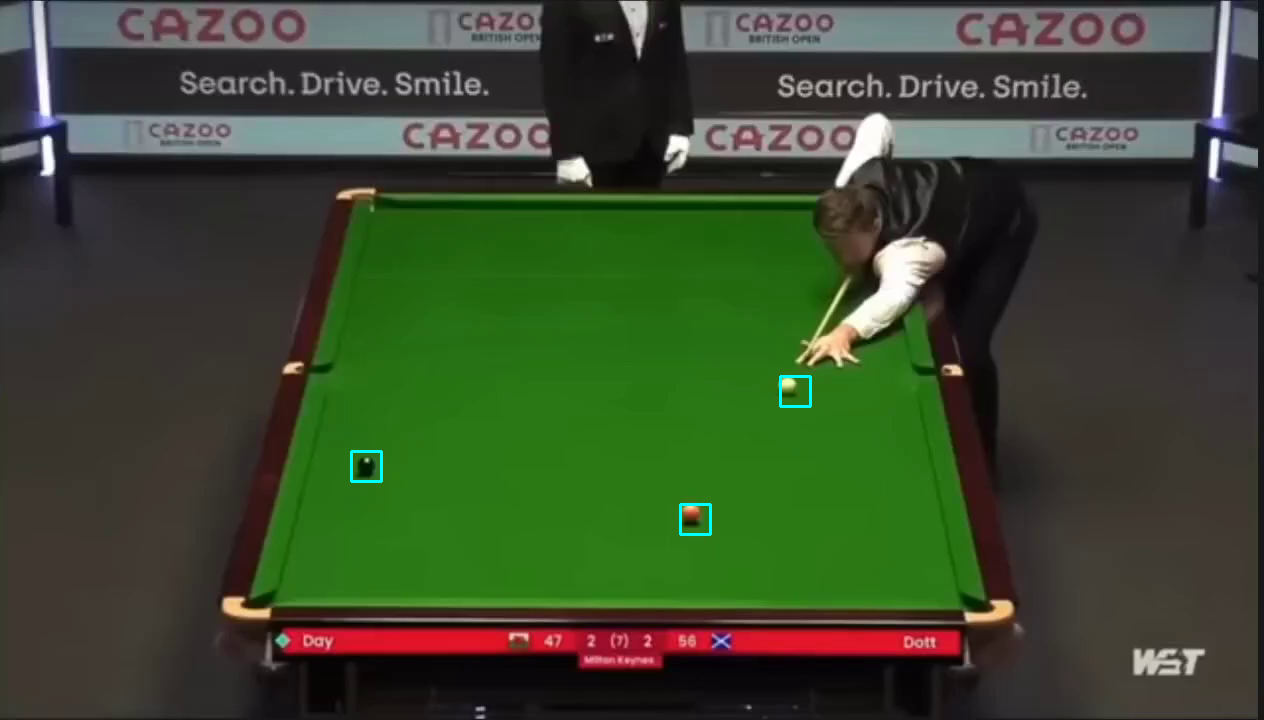

In [17]:
draw_boxes(first_frame, boxes1)

### Przetwarzanie filmu

Mając już wyznaczone początkowe pozycje bil, możemy przejść do przetwarzania całego filmu. Na początek dla każdej z bil utworzymy obiekt śledzący korzystając z funkcji `cv2.TrackerCSRT_create()`.

In [18]:
def get_trackers(boxes, white_box):
    trackers = []
    white = 0
    for i, box in enumerate(boxes):
        cue_ball_tracker = cv2.TrackerCSRT_create()
        cue_ball_tracker.init(first_frame, box)
        trackers.append(cue_ball_tracker)
        if box == white_box:
            white = i
    return trackers, white

Zaimplementujemy funkcje, które przydadzą się podczas przetwarzania filmu.
- funkcja sprawdzająca, czy obszary się nakładają,
- funkcja liczącą prędkość obiektu,
- funkcje sprawdzające, czy obiekt jest w ruchu oraz czy stoi stabilnie.

In [19]:
def boxes_intersect(box1, box2, padding=0):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    left1, right1 = x1 - padding, x1 + w1 + padding
    top1, bottom1 = y1 - padding, y1 + h1 + padding

    left2, right2 = x2, x2 + w2
    top2, bottom2 = y2, y2 + h2

    return not (right1 < left2 or right2 < left1 or bottom1 < top2 or bottom2 < top1)

In [20]:
def compute_velocity(history, frames_back=5):
    if len(history) < frames_back + 1:
        return 0
    (f1, p1), (f2, p2) = history[-frames_back-1], history[-1]
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    dt = f2 - f1
    return ((dx**2 + dy**2)**0.5) / dt if dt else 0

In [21]:
def is_moving_recently(velocities, threshold=1.0, required_frames=10):
    return len(velocities) >= required_frames and all(v >= threshold for v in velocities[-required_frames:])

def is_stopped_recently(velocities, threshold=1.0, required_frames=10):
    return len(velocities) >= required_frames and all(v < threshold for v in velocities[-required_frames:])

Przetworzymy film klatka po klatce. W każdej iteracji wykonujemy następujące operacje:
- zaktualizowanie pozycji obiektów śledzących i ich prędkości,
- wykrycie kontaktu poprzez sprawdzenie, czy dwa obiekty znajdują się blisko siebie i obiekt, który dotychczas był nieruchomy, zaczął się ruszać,
- wykrywanie fauli poprzez sprawdzenie, czy biała bila rozpoczęła i zakończyła swój ruch bez wykrycia żadnego kontaktu między bilami,
- wykrywanie wbicia bili do łuzy poprzez sprawdzenie, czy tracker zgubił obiekt lub znacząco zmienił się kolor obiektu.

In [22]:
def parse_recording(track, trackers, recording, white):
    frame_idx = 0
    alert_frames_remaining = 0

    # Init motion tracking
    position_history = {i: [] for i in range(len(trackers))}
    last_close_frame = {i: -100 for i in range(len(trackers)) if i != white}
    velocity_threshold = 1.5
    closest_distance_to_white = {i: float('inf') for i in range(len(trackers))}

    whiteIsMoving = False
    white_velocity_threshold = 1
    white_contacts = 0
    current_alert_message = ''
    cue_velocity_history = []
    cue_velocity_history_maxlen = 10

    color_history_len = 15
    color_deviation_threshold = 40
    color_history = {i: [] for i in range(len(trackers))}

    while recording.isOpened():
        ret, frame = recording.read()
        alert_frames_remaining -= 1

        if not ret:
            break

        current_boxes = []

        # draw trackers & update history
        for i, tracker in enumerate(trackers):
            ok, bbox = tracker.update(frame)
            if ok:
                current_boxes.append((i, bbox))
                x, y, w, h = bbox
                center = (x + w / 2, y + h / 2)


                position_history[i].append((frame_idx, center))
                if len(position_history[i]) > 10:
                    position_history[i].pop(0)

                # Track average color inside the bounding box
                roi = frame[int(y):int(y + h), int(x):int(x + w)]
                if roi.size > 0:
                    avg_color = np.mean(roi.reshape(-1, 3), axis=0)
                    color_history[i].append(avg_color)
                    if len(color_history[i]) > color_history_len:
                        color_history[i].pop(0)

                if i == white:
                    draw_bbox(frame, bbox, (0, 0, 255))
                else:
                    draw_bbox(frame, bbox, (255, 0, 0))

        cue_box = None
        cue_center = None
        for idx, box in current_boxes:
            if idx == white:
                cue_box = box
                x, y, w, h = cue_box
                cue_center = (x + w / 2, y + h / 2)
                break

        if cue_center:
            cue_radius = cue_box[2] / 2

            for idx, box in current_boxes:
                if idx == white:
                    continue

                x, y, w, h = box
                center = (x + w / 2, y + h / 2)
                ball_radius = w / 2

                center_distance = ((center[0] - cue_center[0]) ** 2 + (center[1] - cue_center[1]) ** 2) ** 0.5
                distance = max(0, center_distance - cue_radius - ball_radius)

                if distance < 50:  # proximity threshold
                    last_close_frame[idx] = frame_idx

                if distance < closest_distance_to_white[idx]:
                    closest_distance_to_white[idx] = distance

            for idx in range(len(trackers)):
                if idx == white:
                    continue
                v = compute_velocity(position_history[idx], frames_back=5)
                if v > velocity_threshold and frame_idx - last_close_frame.get(idx, -100) <= 5:
                    alert_frames_remaining = 20
                    white_contacts += 1
                    current_alert_message = 'CONTACT DETECTED!'
                    break

            if not whiteIsMoving and is_moving_recently(cue_velocity_history, white_velocity_threshold, 10):
                white_contacts = 0
                whiteIsMoving = True

            elif whiteIsMoving and is_stopped_recently(cue_velocity_history, white_velocity_threshold, 10):
                whiteIsMoving = False
                if white_contacts <= 0:
                    alert_frames_remaining = 20
                    current_alert_message = 'FOUL!'
                white_contacts = 0

        # POT detection based on color change
        for i in range(len(trackers)):
            if i == white:
                continue
            history = color_history[i]
            if len(history) >= color_history_len:
                past_avg = np.mean(history[:color_history_len - 5], axis=0)
                recent_avg = np.mean(history[-5:], axis=0)
                color_diff = np.linalg.norm(past_avg - recent_avg)
                if color_diff > color_deviation_threshold:
                    alert_frames_remaining = 20
                    current_alert_message = f'POT DETECTED! (ball {i})'

        if alert_frames_remaining > 0:
            alert_contact(frame, current_alert_message)
        else:
            cue_velocity = compute_velocity(position_history[white], frames_back=5)
            cue_velocity_history.append(cue_velocity)
            if len(cue_velocity_history) > cue_velocity_history_maxlen:
                cue_velocity_history.pop(0)
            last_close = last_close_frame.get(4, -1)

        track.write(frame)
        frame_idx += 1

    track.release()

### Wyniki

Pierwszy film:

In [23]:
trackers, white = get_trackers(boxes1, white_box1)

snooker_width = int(snooker1.get(3))
snooker_height = int(snooker1.get(4))
snooker_fps = snooker1.get(cv2.CAP_PROP_FPS)

cue_ball_track = cv2.VideoWriter('./cue_ball_track1.avi', cv2.VideoWriter_fourcc(*'DIVX'), snooker_fps, (snooker_width, snooker_height))
parse_recording(cue_ball_track, trackers, snooker1, white)

(680, 504, 30, 30)
(780, 376, 30, 30)
(351, 451, 30, 30)


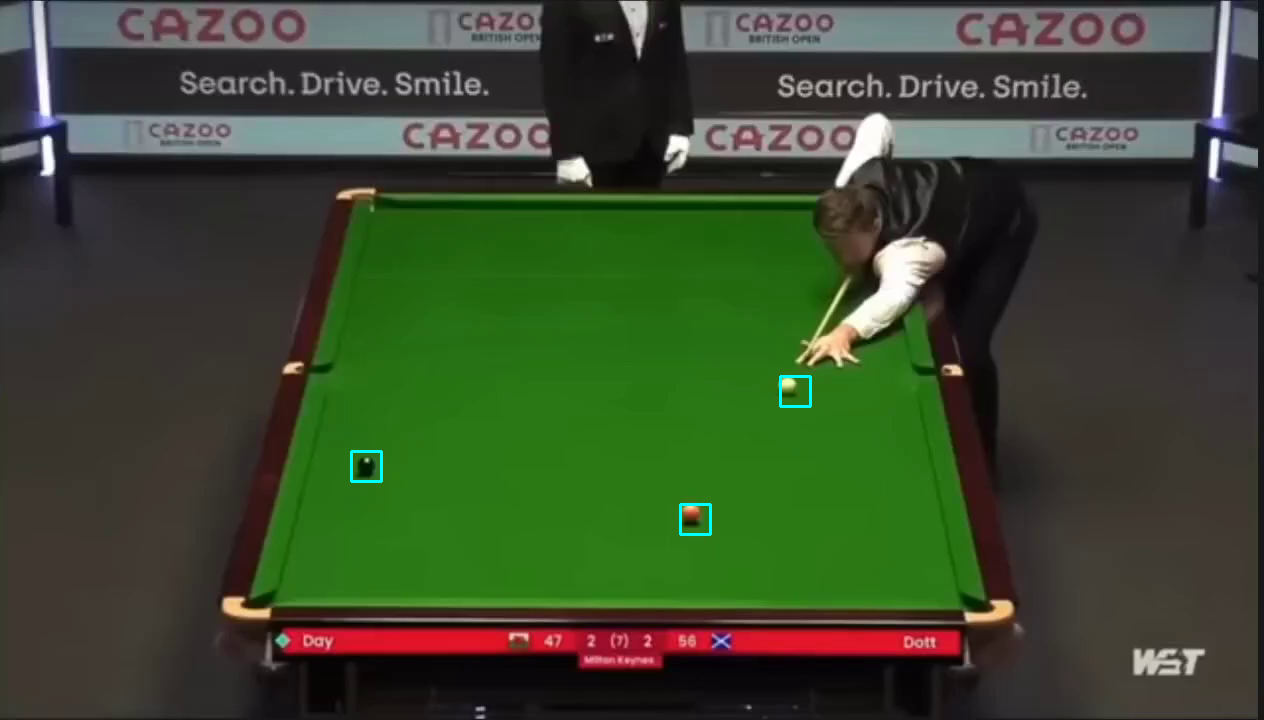

In [24]:
draw_boxes(first_frame, boxes1)

In [25]:
!ffmpeg -hide_banner -loglevel error -i cue_ball_track1.avi -y cue_ball_track1.mp4

In [26]:
Video.from_file('./cue_ball_track1.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x17\xcaUmdat\x00\x…

Drugi film:

In [27]:
# Parametry
HOUGH_PARAM_1 = 70
HOUGH_PARAM_2 = 12
MIN_RADIUS = 20
MAX_RADIUS = 25
BOX_SIZE = 30

In [28]:
snooker2.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, first_frame = snooker2.read()
circles = get_circles(first_frame, HOUGH_PARAM_1, HOUGH_PARAM_2, MIN_RADIUS, MAX_RADIUS)
circles = join_circles(circles)
boxes2 = get_balls(first_frame, circles, BOX_SIZE)
white_box2 = get_cue_ball(first_frame, boxes2)

Znalezionych okręgów BLUE: 12
Znalezionych okręgów GREEN: 14
Znalezionych okręgów RED: 11
Znalezionych okręgów GRAY: 12
Znaleziono 7 bil


(467, 237, 30, 30)
(1121, 361, 30, 30)
(391, 101, 30, 30)
(685, 571, 30, 30)
(712, 328, 30, 30)
(520, 58, 30, 30)
(1078, 160, 30, 30)


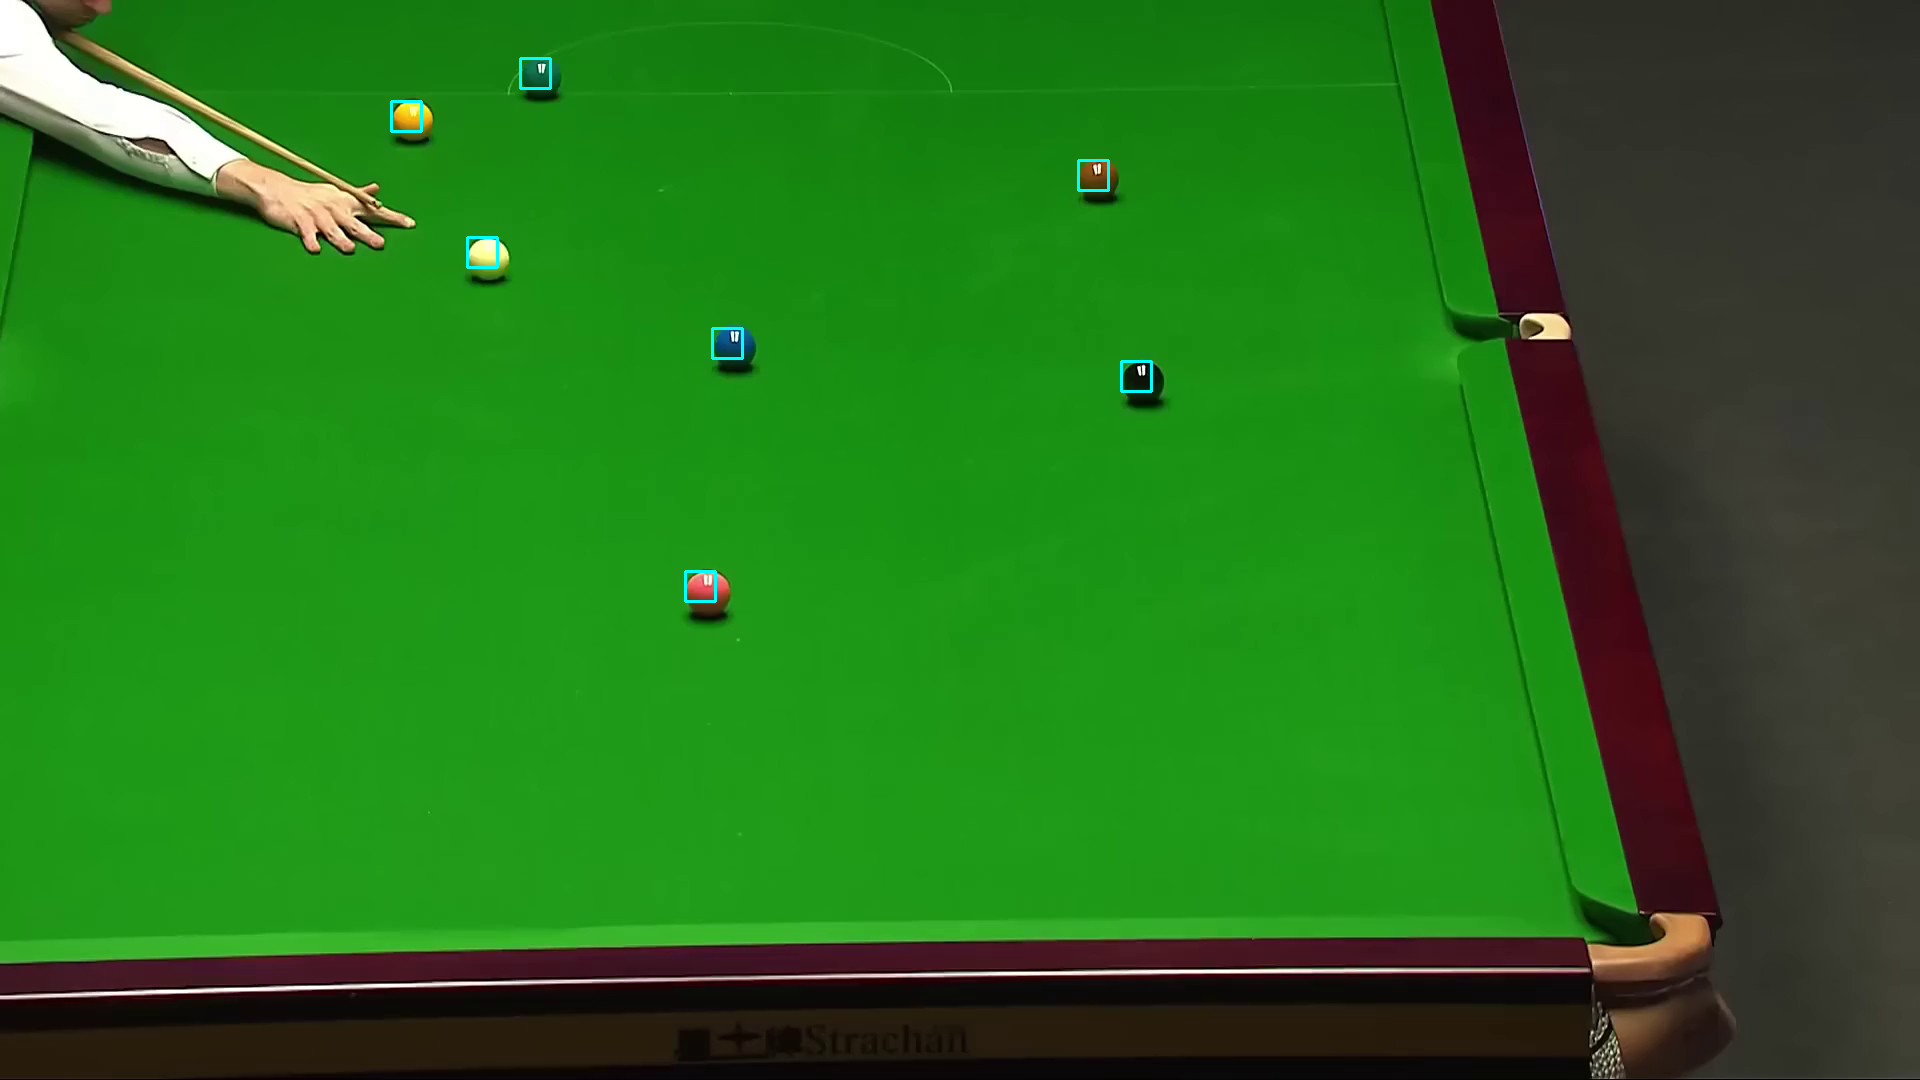

In [29]:
draw_boxes(first_frame, boxes2)

In [30]:
trackers, white = get_trackers(boxes2, white_box2)

snooker_width = int(snooker2.get(3))
snooker_height = int(snooker2.get(4))
snooker_fps = snooker2.get(cv2.CAP_PROP_FPS)

cue_ball_track = cv2.VideoWriter('./cue_ball_track2.avi', cv2.VideoWriter_fourcc(*'DIVX'), snooker_fps, (snooker_width, snooker_height))
parse_recording(cue_ball_track, trackers, snooker2, white)

In [31]:
!ffmpeg -hide_banner -loglevel error -i cue_ball_track2.avi -y cue_ball_track2.mp4

In [32]:
Video.from_file('./cue_ball_track2.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x06\xe5\xf7mdat\x0…

### Podsumowanie

Udało się wykryć wszystkie założone typy zdarzeń. Śledzenie obiektów okazało się stosunkowo łatwe w implementacji - algorytm CSRT z biblioteki OpenCV działa bardzo dobrze. Pewnym wyzwaniem okazało się jednak znalezienie początkowych pozycji bil - funkcja `HoughCircles` znajduje wiele nadmiarowych obiektów, które trzeba było odfiltrować.